In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
! pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rijboy","key":"18b35ccbcc01e1b69c5ba44cec41bfdd"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path} 
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 593M/600M [00:06<00:00, 44.5MB/s]
100% 600M/600M [00:06<00:00, 93.5MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 45.5MB/s]


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
import os
os.listdir('/root/.fastai/data/planet')

['train_v2.csv',
 'train-jpg.tar.7z',
 'train_v2.csv.zip',
 'train-jpg',
 '__MACOSX']

**MultiClassification**

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert = True,max_lighting = 0.1,max_zoom = 1.05,max_warp = 0.)

In [0]:
data = (ImageList.from_csv(path,'train_v2.csv',folder = 'train-jpg',suffix = '.jpg').split_by_rand_pct(0.2).label_from_df(label_delim=' '))

In [0]:
data = data.transform(tfms, size=128).databunch().normalize(imagenet_stats)

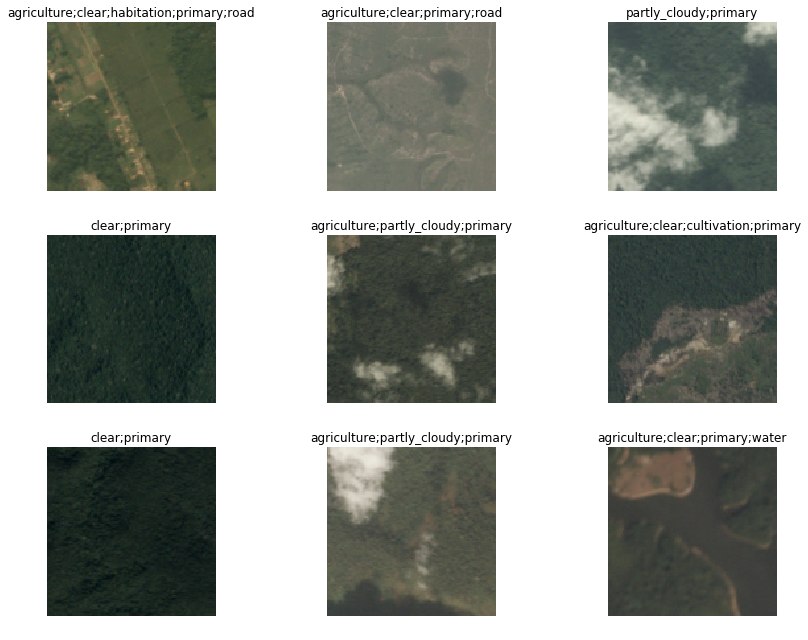

In [0]:
data.show_batch(rows=3,figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh,thresh=0.2)
f_score = partial(fbeta,thresh=0.2)
learn = cnn_learner(data,arch,metrics=[acc_02,f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 59586125.02it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


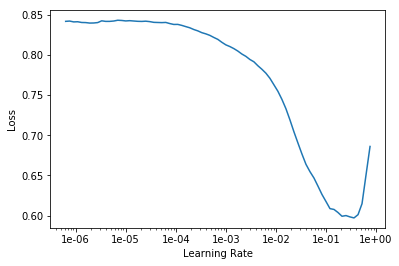

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124073,0.113086,0.940123,0.901525,02:40
1,0.107472,0.101377,0.955150,0.912160,02:37
2,0.101200,0.094159,0.957061,0.919465,02:37
3,0.094413,0.089632,0.955390,0.923958,02:38
4,0.095472,0.088617,0.956829,0.924639,02:38


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


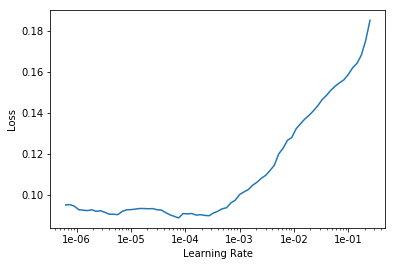

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097750,0.092901,0.954983,0.918610,02:49
1,0.097919,0.089886,0.954925,0.923202,02:49
2,0.091797,0.087325,0.956451,0.926044,02:46
3,0.084627,0.084385,0.957025,0.927743,02:46
4,0.080734,0.084255,0.958588,0.927870,02:45


In [0]:
learn.save('stage2-rn50-unfreeze-learning')

In [0]:
src = (ImageList.from_csv(path,'train_v2.csv',folder = 'train-jpg',suffix = '.jpg').split_by_rand_pct(0.2).label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms,size = 256).databunch().normalize(imagenet_stats))
learn.data = data

In [0]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
data.train_ds

LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,agriculture;clear;habitation;primary;road,haze;primary;water
Path: /root/.fastai/data/planet

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


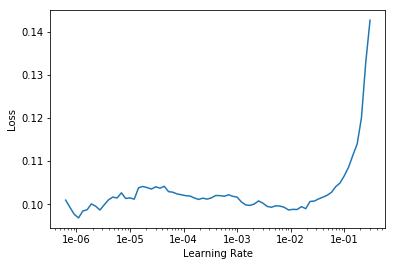

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088929,0.080553,0.959975,0.929181,05:24
1,0.086021,0.076747,0.959271,0.932716,05:21
2,0.084961,0.076184,0.960309,0.933353,05:19
3,0.085723,0.075445,0.958834,0.933904,05:18
4,0.083734,0.075423,0.959241,0.933383,05:18


In [0]:
learn.save('resnet50-256-stage1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5,max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085900,0.076520,0.957759,0.932103,07:02
1,0.086800,0.076608,0.962184,0.934237,07:07
2,0.080603,0.075010,0.960506,0.935250,07:06
3,0.081097,0.074423,0.960390,0.935853,07:06
4,0.078020,0.074147,0.960905,0.935869,07:07
